In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW
torch.set_grad_enabled(False);

In utils/hub.py: default_cache_path: /raid3/xd/.cache/torch/hub->/nas/xd/.cache/torch/transformers/


In [3]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [4]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils_mqy import *
from child_utils import _str, _cxt2str, _item2str, _s, _be
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils'): from model_utils_mqy import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000042
utils ... done 0:00:00.003467
child_utils ... In const.py: Loading tokenizer ... done 0:00:00.190295
done 0:00:03.915501
tasks ... done 0:00:00.001828
model_utils ... done 0:00:08.370531
weight_analysis ... done 0:00:00.000030


In [5]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-neox-20b on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [6]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', #'EleutherAI/gpt-j-6B',
#                    'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b'
                  ]#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 6
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 8; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer

EleutherAI/gpt-j-6B/cpu ... done 0:05:07.162101


In [7]:
model_name = gpt_model_names[0]  # engines[4]
model, tokenizer = models[model_name]
model_name_gpu = model_name.replace('/cpu', '')
model_gpu = models[model_name_gpu][0] if model_name_gpu in models else model

In [8]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

In [9]:
# clone model 
device = torch.device('cuda:5')
_ = clone_model_to(model, device)

cloning GPTJBlock0.ln_1 to cuda:5 ... done 0:00:07.951887
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.036742
cloning GPTJBlock1.ln_1 to cuda:5 ... done 0:00:00.000591
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.031830
cloning GPTJBlock2.ln_1 to cuda:5 ... done 0:00:00.000548
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.028515
cloning GPTJBlock3.ln_1 to cuda:5 ... done 0:00:00.000540
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.029912
cloning GPTJBlock4.ln_1 to cuda:5 ... done 0:00:00.000809
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.028312
cloning GPTJBlock5.ln_1 to cuda:5 ... done 0:00:00.000953
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.027501
cloning GPTJBlock6.ln_1 to cuda:5 ... done 0:00:00.000948
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.027716
cloning GPTJBlock7.ln_1 to cuda:5 ... done 0:00:00.000762
cloning GPTJAttention.out_proj to cuda:5 ... done 0:00:00.027576
cloning GPTJBloc

In [10]:
tasks = [
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(genders_of_persons).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ), 
#      (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#      ), 
#     (lambda: [TreeSet(countries_of_cities).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ),
#     (lambda: fork_vocab(TreeSet(capabilities_of_things), [['equal', 'child', 'sibling']] * 2), MlM_gen, None, None,
#     ), 
#     (lambda: [SymSet(person_adjs).use(['equal']), SymSet(person_adjs).use(['opposite'])], MlM_gen, None, None,
#     ), 
#     (lambda: fork_vocab(PoSet(temporal_posets), [['equal'], ['prev']]), MlM_gen, None, None,
#     ), 
#     (lambda: fork_vocab(PoSet(temporal_posets), [['equal'], ['next']]), MlM_gen, None, None,
#     ), 
#     (lambda: [TreeSet(types_of_characters).use('child'), TreeSet(types_of_things).use('child')], partial(MlM_gen, cxt_sample_fn=enumerate_sample, query=1),
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
#     ),
   (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen,
    partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f"{the_(q)} likes",
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f"What {the_(q)} has is a kind of",
   ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
#    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
#     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}", f"{i[1]} attracts {the_(i[0], uppercase=False)}"]), lambda q, _: f'{the_(q)} wanna go to',
#    ), # t: 19-12 >> 16-10 = 12-7
#    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(capabilities_of_things).use(['child'])], MlM_gen,
#     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f'{q} can'
#    ),
     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Yes, {q} looks", " like"
     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), SymSet(person_adjs).use(['opposite'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{capitalize(i[1])} is {i[0]}"]), lambda q, _: f"{the_(q)} is not",
    ), # t: 16-14, somewhat 14-7 # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f"So {q}'s arrival time", ' is'
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_posets).use(['prev'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}', f'{capitalize(prep_(i[1]))} arrived {i[0]}']), lambda q, _: f'{the_(q)} arrived just before'
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_posets).use(['next'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}', f'{capitalize(prep_(i[1]))} arrived {i[0]}']), lambda q, _: f'{the_(q)} arrived just after'
    ),
]

In [11]:
#print(key); print_tree(r.root)

In [11]:
import copy
results = {}; key = None
#print(device)
#model.lm_head = copy.deepcopy(model_gpu.lm_head)
#model.lm_head.to('cpu')
#print(model.lm_head.weight.device)
#models.keys()
#print(save_results)
# model_gpu.lm_head.to(device)
# print(model_gpu.lm_head.weight.device)
# switch_model_to(model, device)
# print('lm_head', model.lm_head)

In [12]:
results = {}; key = None


-->task: (<function <lambda> at 0x7f617b50e050>, <function MlM_gen at 0x7f6050194680>, functools.partial(<function _cxt2str at 0x7f60501949e0>, item2str=<function <lambda> at 0x7f617b50e0e0>), <function <lambda> at 0x7f617b50e170>) rel0_i:0, rel1_i:0, do_swap_qa:False, do_negate:False, do_rm_query:False, rev_item2str:False, do_g2c:False

== MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.equal][cxt_len=3] == 
David has a laptop. Sharon has a rabbit. Barbara has a plum. Barbara likes plum
Donna has spaghetti. Michael has a plum. John has a jersey. John likes jersey
Steven has vodka. Anthony has a rabbit. Thomas has a pig. Thomas likes pig
John has a goat. Laura has pink. Jeff has a jersey. Laura likes pink
0.8258377909660339 0.7222222222222222
attribute_tree ... attribute_tree 2 []
_topk 10
In attribute_tree: attribute_step , topk=10 ... attr step fns []
post_forward_fn []
num_points 3 0 4
scaled_x_ [('mlp_mask', torch.Size([4, 28])), ('embed_mask', torch.Size([4, 1]))

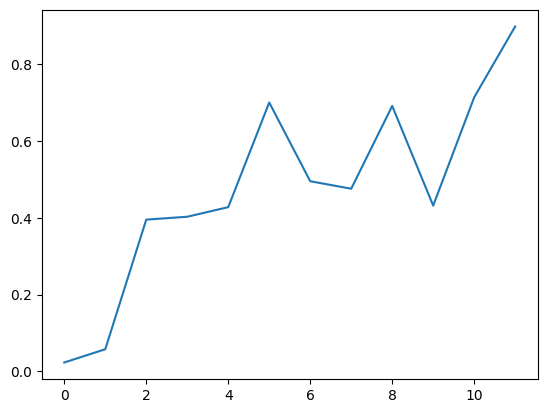

In [51]:
results = {}; key = None
nrows, k_shot = 12, 3; cxt_len = 3; save_results = True
batch_size = 2; verbose = False #not save_results or batch_size <= 8
rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
for task,        rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c in product(
    #tasks[0:1], [0],[1,],[False],  [True],[True,],[False,],[False,]):
    tasks[0:1], [0],[0,],[False],  [False],[False,],[False,],[False,]):
    print('\n-->task:',task, f'rel0_i:{rel0_i}, rel1_i:{rel1_i}, do_swap_qa:{do_swap_qa}, do_negate:{do_negate}, do_rm_query:{do_rm_query}, rev_item2str:{rev_item2str}, do_g2c:{do_g2c}')
#     tasks[0:1],range(1,2),range(1),[True],[False,True],[True],[False,],[False,],[False,]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_task(task, **trans_args)
    if task is None: print('task is None! skip.'); continue
    res_key = f'{task2str(task)}[{args2str(args)}]'# + composed_heads2str(model)
    if key is not None and res_key != key: continue
    if not validate_args(task, args, trans_args): print(f'invalid args {res_key}! skip.'); continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
#     if r is not None: print('duplicate task!'); continue 
    r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
            custom_forward=save_results, result=r, verbose=verbose, **args)
    if save_results: results[res_key] = r
#     if True or not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue
    #switch_model_to(model_gpu, device)
    #print(model.lm_head)
    if True or r.root is None: r.root = add_node(None, layer=L, label_type='labels')
    r.root = attribute_tree_on(r.data_tuples, model, r.root, -1, topk=10, k_shot=k_shot, mix=True, device=device, verbose=True)



In [34]:
import dataclasses
print(len(r.data_tuples))
outputs = r.data_tuples[0][-1]
fields = dataclasses.fields(outputs)
# print(fields)
for fd in fields:
#     print(fd.name)
    v = getattr(outputs, fd.name)
#     print(fd.name, type(v))
    if isinstance(v, torch.Tensor):
        print(fd.name, v.shape)
    elif isinstance(v, tuple) and len(v) >0:
        print(fd.name, len(v),v[0].shape)
    elif isinstance(v, dict):
        print(fd.name, v.keys())
    else:
        print(fd.name, v)
    
#    print(outpuddtsfd)

2
inputs_embeds torch.Size([1, 221, 4096])
position_embeds None
attn_outputs 28 torch.Size([1, 221, 4096])
values 28 torch.Size([1, 16, 221, 256])
attn_outs 28 torch.Size([1, 16, 221, 256])
head_inputs None
head_outputs None
intermediates ()
mlp_outputs 28 torch.Size([1, 221, 4096])
hidden_states 30 torch.Size([1, 221, 4096])
attentions 28 torch.Size([1, 16, 221, 221])
logits torch.Size([1, 221, 50400])
labels None
loss None
attn_attr odict_keys([])


In [50]:
'''
print AttrData and Attributions
'''

attrdata = r.root.data
fields = dataclasses.fields(attrdata)
for fd in fields:
#     print(fd.name, type(getattr(attrdata, fd.name)))
    v = getattr(attrdata, fd.name)
    if isinstance(v, dict):
        print(fd.name, [[_k,(_v.shape if isinstance(_v, torch.Tensor) else _v)] for _k,_v in v.items()])
    else:
        print(fd.name, v if not isinstance(v, Attributions) else 'attr'  )
print('--------------Attributions-----------------')
attribution = attrdata.attr 
fields = dataclasses.fields(attribution)
for fd in fields:
    v = getattr(attribution, fd.name)
    print(fd.name, v if not isinstance(v, torch.Tensor) else v.shape)

'\nprint AttrData and Attributions\n'

step -1
topi None
layer 28
head None
H 64
label_type labels
attn_pattern None
attribute_k False
attr attr
ap_scores [['bos->ans0', torch.Size([28, 16])], ['bos->ans]', torch.Size([28, 16])], ['bos->query', torch.Size([28, 16])], ['bos->ans0+', torch.Size([28, 16])], ['bos->tgt', torch.Size([28, 16])], ['bos->sep', torch.Size([28, 16])], ['bos->sep+', torch.Size([28, 16])], ['bos->query-', torch.Size([28, 16])], ['bos->bos', torch.Size([28, 16])]]
head_label_types {(16, 7, 'attn_labels:bos->~<s>,3'), (13, 7, 'attn_labels:bos->~<s>,3'), (17, 9, 'attn_labels:bos->~<s>,3'), (18, 13, 'attn_labels:bos->~<s>,3'), (19, 4, 'attn_labels:bos->~<s>,3'), (16, 0, 'attn_labels:bos->~<s>,3')}
attr_ap_scores [['bos->ans0', {(18, 13): tensor(0.9330), (16, 7): tensor(0.9523), (13, 7): tensor(0.9237), (16, 0): tensor(0.9425), (23, 14): tensor(0.9308), (19, 4): tensor(0.8385), (18, 9): tensor(0.0857), (17, 9): tensor(0.9146), (21, 13): tensor(0.9429), (20, 1): tensor(0.4251)}], ['bos->ans]', {(18, 13): ten

In [36]:
print_tree(r.root)

 ┌@[0,1,2,3,4,5,7,8,9] 18-13,16-7,13-7,16-0,23-14,19-4,17-9,21-13 29,20-1 29 B->A0 79
 ├@[6] 18-9 unk 0
 ├@0 18-13 100 B->A0 93/22/96/-3.3 attn/ans0s
 ├@0 18-13 100 B->A0 93/22/96/-3.3 attn:B->~<s>
 ├@1 16-7 92 B->A0 95/33/95/-3.5 attn/ans0s
 ├@1 16-7 92 B->A0 95/33/95/-3.5 attn:B->~<s>
 ├@2 13-7 59 B->A0 92/48/91/-3.2 attn/ans0s
 ├@2 13-7 59 B->A0 92/48/91/-3.2 attn:B->~<s>
 ├@3 16-0 55 B->A0 94/36/67/-3.2 attn/ans0s
 ├@3 16-0 55 B->A0 94/36/67/-3.2 attn:B->~<s>
 ├@4 23-14 49 B->A0 93/21/-10/-3.8 attn/ans0s
 ┤
 ├@5 19-4 37 B->A0 84/15/77/-4.0 attn/ans0s
 ├@5 19-4 37 B->A0 84/15/77/-4.0 attn:B->~<s>
 ├@7 17-9 33 B->A0 91/22/88/-3.3 attn/ans0s
 ├@7 17-9 33 B->A0 91/22/88/-3.3 attn:B->~<s>
 ├@40 14-6 7 B->A0/54/52 attn/ans0s
 ├@40 14-6 7 B->A0/54/52 attn:B->~<s>
 ├@396 13-2 -2 B->A0/37/7 attn/ans0s
 ├@396 13-2 -2 B->A0/37/7 attn:B->~<s>
 ├@470 20-0 -31 B->A0/37/72 attn/ans0s
 ├@470 20-0 -31 B->A0/37/72 attn:B->~<s>
 └@6 18-9 34 B->B 54/29/34/-3.7


In [83]:
node = node.parent.parent

NameError: name 'node' is not defined

In [ ]:
print(key); node = result.node = add_node(node, layer=16, head=7, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')  # 

In [ ]:
print(key); node = result.node = add_node(node, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')

### fr->en

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,1,2], k_shot=k_shot)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2], label_type='argmax_attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
analyze_head_chains(model, get_head2scores(result.root.children[1].children[0].children[0]))

### did->does

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1], head_attr_fn=get_head_mlp_attr, mix=True)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

In [ ]:
result.node = result.node.parent.parent.parent
result.node = result.root

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,0,2,7], head_attr_fn=get_head_mlp_attr, label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
for data_tuple in data_tuples:
    plot_attn_attr(data_tuple, model, tokenizer, node, 17, 16, attn_patterns=None, k_shot=0, plot_attr=False)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node.parent, topi=[0,1,6,7,10])

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=10)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 7], head_attr_fn=get_head_mlp_attr)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3], label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr, 

### thing->capability

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[2,1,3,0])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        tokenizer, *args, logits=o.logits, labels=labels, loss_reduction='mean',
        candidates=None, k_shot=k_shot, topk=3, verbose=True)
    print(loss)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0], k_shot=k_shot)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2, 3], k_shot=k_shot, plot_attr=False)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,2,0], label_type='argmax_attn_labels')

### capital->country

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

### person_adjs.opposite

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

### thing->type

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1, 2])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

In [ ]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [ ]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [ ]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [ ]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [ ]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
get_prob_dist(logits.top_logprobs[-1], 5)

In [ ]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [ ]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

In [ ]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [ ]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

In [ ]:
sum(s.count('Yes') for s in input_strs)

In [ ]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [ ]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [ ]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [ ]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [ ]:
trainer.place_model_on_device

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [ ]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])